In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
from local.torch_basics import *
from local.test import *
from local.basics import *
from local.data.all import *
from local.vision import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *
from local.audio.core import *
from local.audio.augment import *
from local.vision.models.xresnet import *
from fastprogress import progress_bar
torch.cuda.synchronize()
from torchaudio.transforms import Spectrogram
import gc

In [27]:
data_path = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'

In [28]:
def load_audio(num=10):
    return [AudioItem.create(data_path.ls()[i]) for i in range(num)]    

### GPU vs CPU Experiment

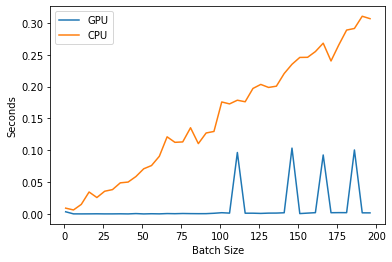

In [29]:
def time_f(f):
    t = time.time()
    res = f()
    return time.time() - t

def plot_gpu_vs_cpu():    
    sg_cuda = Spectrogram().cuda()
    sg_cpu =  Spectrogram()

    def cuda(audios_cuda):
        return sg_cuda(audios_cuda)

    def cpu(audios):
        return sg_cpu(audios)

    crop = CropSignal(8000)
    times = []
    bsr = range(1, 200, 5)
    batch_size = list(bsr) 
    # try:
    bsr = progress_bar(bsr)
    with torch.no_grad():
        for i in bsr:
            audios = [crop(a)[0] for a in load_audio(num=i)]
            audios = torch.cat(audios)
            audios_cuda = audios.clone().cuda()
            res = time_f(partial(cuda, audios_cuda)),  time_f(partial(cpu, audios))
            times.append(res)
            gc.collect()
    
    gpu_times, cpu_times = list(zip(*times))
    plt.plot(batch_size[:len(gpu_times)], gpu_times, label='GPU')
    plt.plot(batch_size[:len(gpu_times)], cpu_times, label='CPU')
    
    plt.legend()
    plt.xlabel('Batch Size')
    plt.ylabel('Seconds')
    plt.show()
plot_gpu_vs_cpu()

In [6]:
def AudioBlock(cls=AudioItem): return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
a2mfcc = AudioToMFCC(n_mffc=20, melkwargs={"n_fft":2048, "hop_length":256, "n_mels":128})
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])


In [7]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))


In [8]:
class AudioToSpecCuda(AudioToSpec):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transformer = self.transformer.cuda()
        
    def encodes(self, x:Tensor) -> Tensor:
        if x.dim() == 3:
            return self.transformer(x[:, -1, :])[:, None].detach()
        return x

### V2 Integrated AudioToSpec GPU Transform

In [9]:
a2s = AudioToSpec.from_cfg(AudioConfig.Voice())
crop_2000ms = CropSignal(2000)
def tosig(t:AudioItem):return t.sig
tfms = Pipeline([crop_2000ms, a2s], as_item=True)
ctfms = Pipeline([crop_2000ms, tosig], as_item=True)
btfms = Pipeline([AudioToSpecCuda()], as_item=True)
cauds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

def run_learner(bs):
    print("CPU")
    
    dbunch = auds.databunch(p10speakers, item_tfms=tfms, bs=bs)
    learn = Learner(dbunch,
                xresnet18(),  
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
    alter_learner(learn)
    learn.fit_one_cycle(2)
    
def run_learner_cuda(bs):
    print("GPU")
    dbunch = cauds.databunch(p10speakers, item_tfms=ctfms, batch_tfms=btfms, bs=bs)
    learn = Learner(dbunch,
                xresnet18(),  
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
    alter_learner(learn)
    learn.fit_one_cycle(2)
    
def run_exp():
    times = []
    bsr = range(64, 200, 5)
    batch_size = list(bsr) 
    # try:
    bsr = progress_bar(bsr)
    try:
        for i in bsr:
            res = time_f(partial(run_learner_cuda, i)), time_f(partial(run_learner, i))
            times.append(res)
            try: 1/0 
            except: pass
            gc.collect()
    except RuntimeError as e:
        print(e)
    
    gpu_times, cpu_times = list(zip(*times))
    plt.plot(batch_size[:len(gpu_times)], gpu_times, label='GPU')
    plt.plot(batch_size[:len(gpu_times)], cpu_times, label='CPU')
    plt.legend()
    plt.xlabel('Batch Size')
    plt.ylabel('Seconds')
    plt.show()
# run_exp()

### SpecAugment Mask Freq + Time

In [11]:
@torch.jit.script
def torchrint(max_y:int, bs:int):
    return torch.randint(0,max_y,(1,bs)).squeeze()

@torch.jit.script
def spec_aug_loop(sg_batch:Tensor, size:int=20):
    bsg = sg_batch.data.clone()
    max_y = bsg.shape[-2]-size-1
    for i in range(bsg.shape[0]):
        s = bsg[i, :]
        m = s.flatten(-2).mean()
        r = torch.randint(0,max_y,(1,)).squeeze().int()
        s[:, r:r+size, :] = m
    return bsg



def get_arrange(x,y,bs,device):
    cache = None
    k = f"{x},{y},{bs}"
    try:
        cache = tcache[k]
    except KeyError:
        pass

    if isinstance(cache, Tensor): return cache
    cache = torch.arange(y, dtype=torch.uint8,device=device).repeat(x*bs).view(bs, -1)
    tcache[k] = cache
    return cache

# @torch.jit.script
@torch.no_grad()
def spec_augment(sgs:Tensor, size:int=20):
    bsg = sgs.data
    device = sgs.device
    bs, _, x, y = bsg.shape
    max_y = y-size-1
    rs = torch.randint(0, max_y,(bs,1), device=device)
    m = torch.arange(y,device=device).repeat(bs, x)
    gpumask = ((m < rs) | (m > (rs+size))).view(bs, 1, x, -1)
    return gpumask*bsg

In [16]:
dbunch = auds.databunch(data_path, item_tfms=tfms, bs=512)
batch = dbunch.one_batch()[0]

In [17]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
        spec_augment(batch)

print(prof)

----------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  -----------------------------------  
Name        Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  Input Shapes                         
----------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  -----------------------------------  
repeat      45.62%           4.599ms          45.62%           4.599ms          4.599ms          36.29%           5.785ms          5.785ms          1                []                                   
lt          13.16%           1.327ms          13.16%           1.327ms          1.327ms          12.81%           2.042ms          2.042ms          1                []                    

In [18]:
batch = dbunch.one_batch()[0]
cpub = batch.clone().cpu()

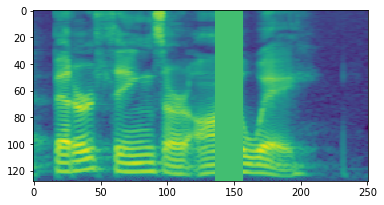

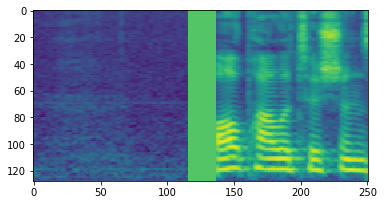

In [19]:
x = spec_augment(batch).clone().cpu()
for i in x[:2].cpu():
    plt.imshow(i[0])
    plt.show()

In [20]:
%%timeit
spec_augment(batch)

6.48 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
spec_aug_loop(cpub)